# Compare Library Complexity - scCLEAN vs Control

complexity metric = how many genes are identified per cell for every unique molecule sequenced

What is the change in the distirbution of gene coverage 

What is the optimal number of principle components according to Random Matrix theory

Samples:
 - Experimental control (n=1) and depleted (n=3)
 - Publicly available deep sequenced    
    Downloaded from 10X Genomics’ dataset repository
    http://cf.10xgenomics.com/samples/cellexp/3.0.2/5k_pbmc_v3/5k_pbmc_v3_filtered_feature_bc_matrix.h5
 - in-silico depleted
 - reference atlas from scArches 
    'rare_pdc_pbmc.h5ad'
    (https://drive.google.com/drive/folders/1QQXDuUjKG8CTnwWW_u83MDtdrBXr8Kpq)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pegasus as pg
import scanpy as sc 
import matplotlib.pyplot as plt
import scipy.sparse

from scipy.stats import mannwhitneyu, normaltest
from adjustText import adjust_text
from pandas.api.types import (
    is_numeric_dtype
)
from scipy.stats import rankdata
from statannotations.Annotator import Annotator
from pegasus.tools import largest_variance_from_random_matrix

/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read in all of the samples used for comparison 

In [2]:
# experimental Control sample - no scCLEAN
data = pg.read_input('raw_files/FUll_transcriptome/Control_not_masked_filtered_feature_bc_matrix.h5')
pg.qc_metrics(data, min_genes=200, min_umis=500, max_genes=40000, mito_prefix='MT-', percent_mito=100)
pg.filter_data(data)

ctrlg = pd.DataFrame(data.obs)
ctrlg['Gene/UMI'] = ctrlg['n_genes']/ctrlg['n_counts']
ctrlg['logGene/UMI'] = np.log10(ctrlg['n_genes'])/np.log10(ctrlg['n_counts'])
ctrlg['name'] = '10x-V3 (exp)'

# 80,000 reads per cell control - taken from 10x Genomics website 
# 5k Peripheral Blood Mononuclear Cells (PBMCs) from a Healthy Donor (v3 chemistry)
sat_data = pg.read_input('Azimuth_annotations/5k_pbmc_v3_filtered_feature_bc_matrix.h5')
pg.qc_metrics(sat_data, min_genes=200, min_umis=500, max_genes=40000, mito_prefix='MT-', percent_mito=100)
pg.filter_data(sat_data)

satdf = pd.DataFrame(sat_data.obs)
satdf['Gene/UMI'] = satdf['n_genes']/satdf['n_counts']
satdf['logGene/UMI'] = np.log10(satdf['n_genes'])/np.log10(satdf['n_counts'])
satdf['name'] = '10x-V3 (~80k)'

# in-silico depleted sample 
idata = pg.read_input('Azimuth_annotations/insilico_depleted_revised.h5')
pg.qc_metrics(idata, min_genes=200, min_umis=500, max_genes=40000, mito_prefix='MT-', percent_mito=100)
pg.filter_data(idata)

dep_ins = pd.DataFrame(idata.obs)
dep_ins['Gene/UMI'] = dep_ins['n_genes']/dep_ins['n_counts']
dep_ins['logGene/UMI'] = np.log10(dep_ins['n_genes'])/np.log10(dep_ins['n_counts'])
dep_ins['name'] = 'scCLEAN (in-silico)'

# PBMC reference samples from scArches using 3 different samples 
rdata = pg.read_input('scArches_reference_mapping/rare_pdc_pbmc.h5ad')
pg.qc_metrics(rdata, min_genes=200, min_umis=500, max_genes=40000, mito_prefix='MT-', percent_mito=100)
pg.filter_data(rdata)
rdata = rdata[rdata.obs['tissue']=='PBMCs']

ref = pd.DataFrame(rdata.obs)
ref['Gene/UMI'] = ref['n_genes']/ref['n_counts']
ref['logGene/UMI'] = np.log10(ref['n_genes'])/np.log10(ref['n_counts'])
ref['name'] = 'PBMC Reference'

# scCLEAN depleted sample rep 1
d1data = pg.read_input('raw_files/FUll_transcriptome/Dep_rep1_not_masked_filtered_feature_bc_matrix.h5')
pg.qc_metrics(d1data, min_genes=200, min_umis=500, max_genes=40000, mito_prefix='MT-', percent_mito=100)
pg.filter_data(d1data)

deplg1 = pd.DataFrame(d1data.obs)
deplg1['Gene/UMI'] = deplg1['n_genes']/deplg1['n_counts']
deplg1['logGene/UMI'] = np.log10(deplg1['n_genes'])/np.log10(deplg1['n_counts'])
deplg1['name'] = 'scCLEAN 1'

# scCLEAN depleted sample rep 2
d2data = pg.read_input('raw_files/FUll_transcriptome/Dep_rep2_not_masked_filtered_feature_bc_matrix.h5')
pg.qc_metrics(d2data, min_genes=200, min_umis=500, max_genes=40000, mito_prefix='MT-', percent_mito=100)
pg.filter_data(d2data)

deplg2 = pd.DataFrame(d2data.obs)
deplg2['Gene/UMI'] = deplg2['n_genes']/deplg2['n_counts']
deplg2['logGene/UMI'] = np.log10(deplg2['n_genes'])/np.log10(deplg2['n_counts'])
deplg2['name'] = 'scCLEAN 2'

# scCLEAN depleted sample rep 3
ddata = pg.read_input('raw_files/FUll_transcriptome/Dep_rep3_not_masked_filtered_feature_bc_matrix.h5')
pg.qc_metrics(ddata, min_genes=200, min_umis=500, max_genes=40000, mito_prefix='MT-', percent_mito=100)
pg.filter_data(ddata)

deplg = pd.DataFrame(ddata.obs)
deplg['Gene/UMI'] = deplg['n_genes']/deplg['n_counts']
deplg['logGene/UMI'] = np.log10(deplg['n_genes'])/np.log10(deplg['n_counts'])
deplg['name'] = 'scCLEAN 3'


2024-11-15 16:27:57,774 - pegasusio.readwrite - INFO - 10x file 'raw_files/FUll_transcriptome/Control_not_masked_filtered_feature_bc_matrix.h5' is loaded.
2024-11-15 16:27:57,775 - pegasusio.readwrite - INFO - Function 'read_input' finished in 4.28s.
2024-11-15 16:27:58,432 - pegasusio.qc_utils - INFO - After filtration, 11484 out of 11714 cell barcodes are kept in UnimodalData object GRCh38-rna.
2024-11-15 16:27:58,433 - pegasus.tools.preprocessing - INFO - Function 'filter_data' finished in 0.26s.
2024-11-15 16:27:59,299 - pegasusio.readwrite - INFO - 10x file 'Azimuth_annotations/5k_pbmc_v3_filtered_feature_bc_matrix.h5' is loaded.
2024-11-15 16:27:59,300 - pegasusio.readwrite - INFO - Function 'read_input' finished in 0.86s.
2024-11-15 16:27:59,597 - pegasusio.qc_utils - INFO - After filtration, 4962 out of 5025 cell barcodes are kept in UnimodalData object GRCh38-rna.
2024-11-15 16:27:59,597 - pegasus.tools.preprocessing - INFO - Function 'filter_data' finished in 0.19s.
2024-11-1

In [3]:
# merge all samples and the key metric of Genes per UMI
ctrl = pd.DataFrame(ctrlg[['Gene/UMI','name']])
ctrl = ctrl.reset_index(drop=True)

depl3 = pd.DataFrame(deplg[['Gene/UMI','name']])
depl3 = depl3.reset_index(drop=True)

depl2 = pd.DataFrame(deplg2[['Gene/UMI','name']])
depl2 = depl2.reset_index(drop=True)

depl1 = pd.DataFrame(deplg1[['Gene/UMI','name']])
depl1 = depl1.reset_index(drop=True)

depl_i = pd.DataFrame(dep_ins[['Gene/UMI','name']])
depl_i = depl_i.reset_index(drop=True)

ref_df = pd.DataFrame(ref[['Gene/UMI','name']])
ref_df = ref_df.reset_index(drop=True)

deep_seq = pd.DataFrame(satdf[['Gene/UMI','name']])
deep_seq = deep_seq.reset_index(drop=True)

merged = pd.concat([deep_seq,ref_df,ctrl,depl_i,depl1,depl2,depl3])
merged = merged.reset_index(drop=True)
merged['gene_per_umi'] = merged['Gene/UMI']
merged

,Gene/UMI,name,gene_per_umi
0,0.258772,10x-V3 (~80k),0.258772
1,0.266893,10x-V3 (~80k),0.266893
2,0.359667,10x-V3 (~80k),0.359667
3,0.310815,10x-V3 (~80k),0.310815
4,0.218944,10x-V3 (~80k),0.218944
...,...,...,...
85456,0.643564,scCLEAN 3,0.643564
85457,0.574373,scCLEAN 3,0.574373
85458,0.484866,scCLEAN 3,0.484866
85459,0.757422,scCLEAN 3,0.757422


In [5]:
#median metrics for complexity
print('median control 80k reads/cell = ' + str(round(satdf['Gene/UMI'].median(),2)))
print('median control reference = ' + str(round(ref['Gene/UMI'].median(),2)))
print('median control = ' + str(round(ctrlg['Gene/UMI'].median(),2)))
print('median depleted insilico = ' + str(round(dep_ins['Gene/UMI'].median(),2)))
print('median depleted 3 = ' + str(round(deplg['Gene/UMI'].median(),2)))
print('median depleted 2 = ' + str(round(deplg2['Gene/UMI'].median(),2)))
print('median depleted 1 = ' + str(round(deplg1['Gene/UMI'].median(),2)))


median control 80k reads/cell = 0.27
median control reference = 0.29
median control = 0.31
median depleted insilico = 0.47
median depleted 3 = 0.64
median depleted 2 = 0.65
median depleted 1 = 0.65


/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/jbezney/minif

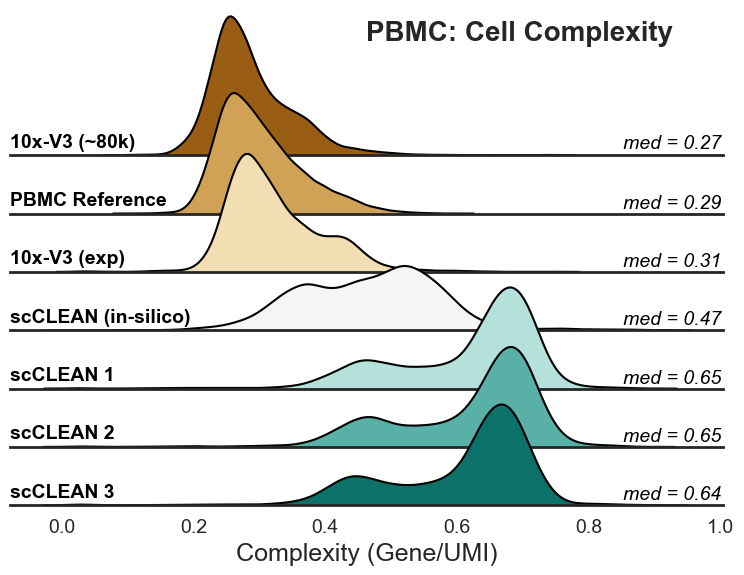

In [6]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})

colors = ["#7C7C7C", "#92DCE5", '#2B303A', '#D64933']
palette = sns.set_palette(sns.color_palette(colors))

#'PuOr',"BrBG"
g = sns.FacetGrid(merged, palette="BrBG", row="name", hue="name", aspect=9, height=1.2)
g.fig.set_size_inches(8,6)


g.map_dataframe(sns.kdeplot, x="gene_per_umi", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="gene_per_umi", color='black')
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .09, label, color='black', fontsize=14,
            ha="left", va="center", fontweight='semibold',transform=ax.transAxes)
    
g.map(label, "name")
g.fig.subplots_adjust(hspace=-.6)
g.set_titles("")
g.set(yticks=[], xlabel="Complexity (Gene/UMI)", ylabel='')
g.despine(left=True)

plt.text(1.0, 22.45, ('med = ' + str(round(satdf['Gene/UMI'].median(),2))), 
         fontsize=14, horizontalalignment='right', color='black', fontfamily='sans-serif', fontstyle='italic')
plt.text(1.0, 18.7, ('med = ' + str(round(ref['Gene/UMI'].median(),2))), 
         fontsize=14, horizontalalignment='right', color='black', fontfamily='sans-serif', fontstyle='italic')
plt.text(1.0, 15.04, ('med = ' + str(round(ctrlg['Gene/UMI'].median(),2))), 
         fontsize=14, horizontalalignment='right', color='black', fontfamily='sans-serif', fontstyle='italic')
plt.text(1.0, 11.38, ('med = ' + str(round(dep_ins['Gene/UMI'].median(),2))), 
         fontsize=14, horizontalalignment='right', color='black', fontfamily='sans-serif', fontstyle='italic')
plt.text(1.0, 7.7, ('med = ' + str(round(deplg1['Gene/UMI'].median(),2))), 
         fontsize=14, horizontalalignment='right', color='black', fontfamily='sans-serif', fontstyle='italic')
plt.text(1.0, 4.0, ('med = ' + str(round(deplg2['Gene/UMI'].median(),2))), 
         fontsize=14, horizontalalignment='right', color='black', fontfamily='sans-serif', fontstyle='italic')
plt.text(1.0, 0.4, ('med = ' + str(round(deplg['Gene/UMI'].median(),2))), 
         fontsize=14, horizontalalignment='right', color='black', fontfamily='sans-serif', fontstyle='italic')

plt.title('PBMC: Cell Complexity', pad=230, fontdict={'fontsize': 20,
 'fontweight' : 'bold',
 'verticalalignment': 'baseline',
 'horizontalalignment': 'left'})

plt.xlabel('Complexity (Gene/UMI)', fontsize=18)
plt.xticks(fontsize=14)
plt.savefig('Figures/complexity_all_conditions_ridgplot.png', dpi=300)
plt.show()

In [18]:
#check for the statistical significance
control = merged.loc[(merged.name == "10x-V3"), "gene_per_umi"].values
dep1 = merged.loc[(merged.name == "scCLEAN 1"), "gene_per_umi"].values
dep2 = merged.loc[(merged.name == "scCLEAN 2"), "gene_per_umi"].values
dep3 = merged.loc[(merged.name == "scCLEAN 3"), "gene_per_umi"].values

stat_results = [mannwhitneyu(dep1, control, alternative="two-sided")]
pvalues = [result.pvalue for result in stat_results]
print("10x-V3 vs Depleted rep1: \n", stat_results[0], "\n")

stat_results2 = [mannwhitneyu(dep2, control, alternative="two-sided")]
pvalues2 = [result.pvalue for result in stat_results2]
print("10x-V3 vs Depleted rep2: \n", stat_results2[0], "\n")

stat_results3 = [mannwhitneyu(dep3, control, alternative="two-sided")]
pvalues3 = [result.pvalue for result in stat_results3]
print("10x-V3 vs Depleted rep3: \n", stat_results3[0], "\n")

10x-V3 vs Depleted rep1: 
 MannwhitneyuResult(statistic=137864928.0, pvalue=0.0) 

10x-V3 vs Depleted rep2: 
 MannwhitneyuResult(statistic=141010469.0, pvalue=0.0) 

10x-V3 vs Depleted rep3: 
 MannwhitneyuResult(statistic=128881104.5, pvalue=0.0) 



# Compare Genes and UMIs Detected

In [11]:
#experimental control
data = sc.read_10x_h5('raw_files/FUll_transcriptome/Control_not_masked_filtered_feature_bc_matrix.h5')
data.var_names_make_unique()
sc.pp.filter_cells(data, min_genes=200)
sc.pp.filter_genes(data, min_cells=5)
sc.pp.calculate_qc_metrics(data, inplace=True)
sc.pp.filter_cells(data, max_counts=np.percentile(data.obs['total_counts'], 95))

#create dataframe to combine for violin comparison 
C_DF = data.obs[['pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
               'pct_counts_in_top_500_genes']].reset_index(drop=True)
C_DF2 = pd.melt(C_DF, var_name='Column Name', value_name='Value')
C_DF2['Condition'] = '10X-V3 (exp)'

#experimental dep1
data1 = sc.read_10x_h5('raw_files/FUll_transcriptome/Dep_rep1_not_masked_filtered_feature_bc_matrix.h5')
data1.var_names_make_unique()
sc.pp.filter_cells(data1, min_genes=200)
sc.pp.filter_genes(data1, min_cells=5)
sc.pp.calculate_qc_metrics(data1, inplace=True)
sc.pp.filter_cells(data1, max_counts=np.percentile(data1.obs['total_counts'], 95))

#create dataframe to combine for violin comparison 
D1_DF = data1.obs[['pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
               'pct_counts_in_top_500_genes']].reset_index(drop=True)
D1_DF2 = pd.melt(D1_DF, var_name='Column Name', value_name='Value')
D1_DF2['Condition'] = 'scCLEAN 1'

#experimental dep2
data2 = sc.read_10x_h5('raw_files/FUll_transcriptome/Dep_rep2_not_masked_filtered_feature_bc_matrix.h5')
data2.var_names_make_unique()
sc.pp.filter_cells(data2, min_genes=200)
sc.pp.filter_genes(data2, min_cells=5)
sc.pp.calculate_qc_metrics(data2, inplace=True)
sc.pp.filter_cells(data2, max_counts=np.percentile(data2.obs['total_counts'], 95))

#create dataframe to combine for violin comparison 
D2_DF = data2.obs[['pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
               'pct_counts_in_top_500_genes']].reset_index(drop=True)
D2_DF2 = pd.melt(D2_DF, var_name='Column Name', value_name='Value')
D2_DF2['Condition'] = 'scCLEAN 2'

#experimental dep3
data3 = sc.read_10x_h5('raw_files/FUll_transcriptome/Dep_rep3_not_masked_filtered_feature_bc_matrix.h5')
data3.var_names_make_unique()
sc.pp.filter_cells(data3, min_genes=200)
sc.pp.filter_genes(data3, min_cells=5)
sc.pp.calculate_qc_metrics(data3, inplace=True)
sc.pp.filter_cells(data3, max_counts=np.percentile(data3.obs['total_counts'], 95))

#create dataframe to combine for violin comparison 
D3_DF = data3.obs[['pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
               'pct_counts_in_top_500_genes']].reset_index(drop=True)
D3_DF2 = pd.melt(D3_DF, var_name='Column Name', value_name='Value')
D3_DF2['Condition'] = 'scCLEAN 3'

#deep sequenced PBMC samples from 10x 
dataS = sc.read_10x_h5('Azimuth_annotations/5k_pbmc_v3_filtered_feature_bc_matrix.h5', gex_only=True)
dataS.var_names_make_unique()
sc.pp.filter_cells(dataS, min_genes=200)
sc.pp.filter_genes(dataS, min_cells=5)
sc.pp.calculate_qc_metrics(dataS, inplace=True)
sc.pp.filter_cells(dataS, max_counts=np.percentile(dataS.obs['total_counts'], 95))

#create dataframe to combine for violin comparison 
S_DF = dataS.obs[['pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
               'pct_counts_in_top_500_genes']].reset_index(drop=True)
S_DF2 = pd.melt(S_DF, var_name='Column Name', value_name='Value')
S_DF2['Condition'] = '10X-V3 (~80k reads/cell)'

#in silico depleted samples 
dataI = sc.read_10x_h5('Azimuth_annotations/insilico_depleted_revised.h5')
dataI.var_names_make_unique()
sc.pp.filter_cells(dataI, min_genes=200)
sc.pp.filter_genes(dataI, min_cells=5)
sc.pp.calculate_qc_metrics(dataI, inplace=True)
sc.pp.filter_cells(dataI, max_counts=np.percentile(dataI.obs['total_counts'], 95))

#create dataframe to combine for violin comparison 
I_DF = dataI.obs[['pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
               'pct_counts_in_top_500_genes']].reset_index(drop=True)
I_DF2 = pd.melt(I_DF, var_name='Column Name', value_name='Value')
I_DF2['Condition'] = 'scCLEAN (insilico)'

#reference samples from scArches
dataR = sc.read_h5ad('scArches_reference_mapping/rare_pdc_pbmc.h5ad')
dataR.var_names_make_unique()
dataR = dataR[dataR.obs['tissue']=='PBMCs']
sc.pp.filter_cells(dataR, min_genes=200)
sc.pp.filter_genes(dataR, min_cells=5)
sc.pp.calculate_qc_metrics(dataR, inplace=True)
sc.pp.filter_cells(dataR, max_counts=np.percentile(dataR.obs['total_counts'], 95))

#create dataframe to combine for violin comparison 
R_DF = dataR.obs[['pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
               'pct_counts_in_top_500_genes']].reset_index(drop=True)
R_DF2 = pd.melt(R_DF, var_name='Column Name', value_name='Value')
R_DF2['Condition'] = 'PBMC scArches Reference'

/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/annd

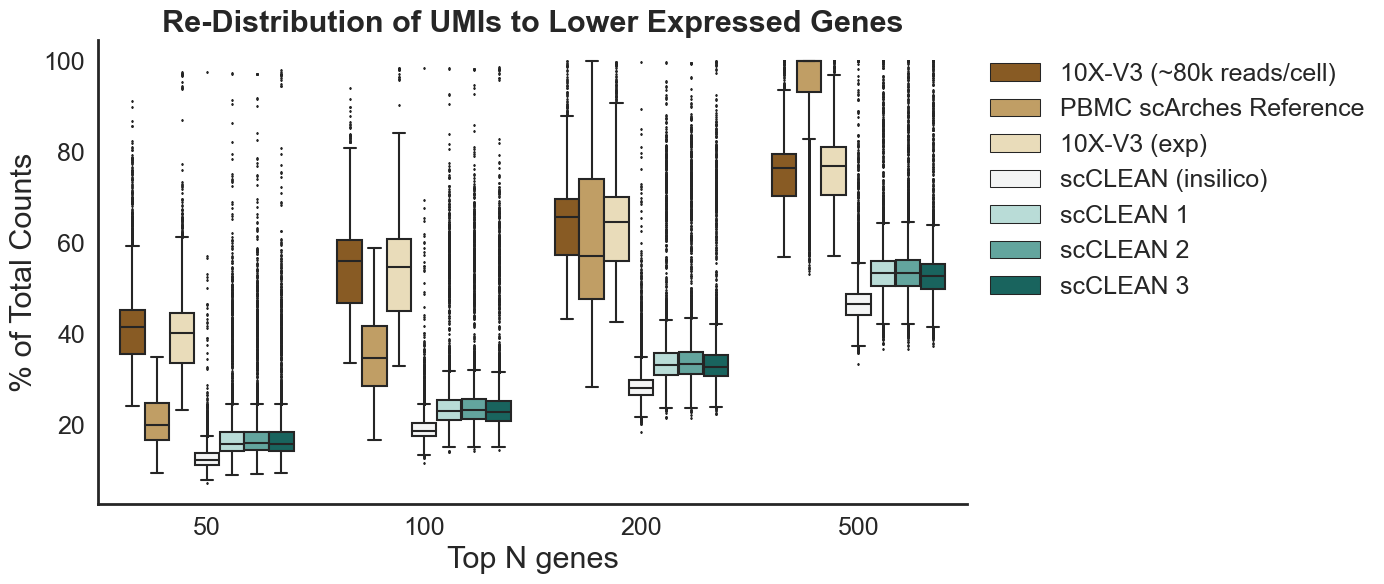

In [12]:
#combine dataframes and plot 
merged = pd.concat([S_DF2, R_DF2, C_DF2, I_DF2, D1_DF2, D2_DF2, D3_DF2])

fig, axes = plt.subplots(figsize=(14,6))
sns.boxplot(data=merged, x='Column Name', y='Value', hue='Condition', ax = axes, width=.8,
             palette="BrBG", fliersize=1)

right_side = axes.spines["right"]
right_side.set_visible(False)
top = axes.spines["top"]
top.set_visible(False)

x = [0,1,2,3]
labels = ['50', '100', '200', '500']
plt.xticks(x, labels, fontsize=18)
plt.yticks(fontsize=18)

plt.title('Re-Distribution of UMIs to Lower Expressed Genes', fontweight="bold", fontsize=22)
plt.ylabel('% of Total Counts', fontsize=22)
plt.xlabel('Top N genes', fontsize=22, )
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=18, frameon=False)
plt.tight_layout()
plt.savefig('Figures/Boxplot_all_pct_counts_in_top_N_genes.png', dpi=300)
plt.show()

In [14]:
# get the boxplot metrics and save to a text file for supplementary table 4 
def calculate_boxplot_metrics(df, group_cols, value_col):
    # Group by the relevant columns (Condition and Column Name)
    stats = df.groupby(group_cols)[value_col].describe(percentiles=[.25, .5, .75])
    
    stats = stats[['min', '25%', '50%', '75%', 'max']]
    stats.columns = ['Min', '25th Percentile', 'Median', '75th Percentile', 'Max']
    
    return stats

# Calculate metrics for each group and save to a text file
metrics = calculate_boxplot_metrics(merged, ['Condition', 'Column Name'], 'Value')

with open('boxplot_metrics_figure2b.txt', 'w') as f:
    f.write(metrics.to_string())
    


# Compare PCs calculated using Random Matrix Theory

In [2]:
#for the scArches reference, select only one of the PBMC datasets used to build the reference 
#otherwise the batches are captured as the 'biological' variation, need an apples to apples comparison for PCA
#thus every condition consists of 1 raw data sample without any batch effects

#https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.2.0/pbmc4k?
#https://f1000research.com/articles/7-1297/v1
#Freytag 4k PBMCs

In [19]:
def process_dataset(file_path, dataset_name, file_type='h5', gex_only=False):
    # Load the dataset based on file type
    if file_type == 'h5':
        adata = sc.read_10x_h5(file_path, gex_only=gex_only)
    elif file_type == 'mtx':
        adata = sc.read_10x_mtx(file_path)
    elif file_type == 'h5ad':
        adata = sc.read_h5ad(file_path)
    else:
        raise ValueError(f"Unsupported file type: {file_type}")
    
    adata.var_names_make_unique()
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=5)
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=0.01, min_disp=0.2)
    sc.tl.pca(adata)
    
    # Use Random Matrix Theory to determine the optimal number of PCs
    nfeatures = adata.var['highly_variable'].sum()
    thre = largest_variance_from_random_matrix(adata.shape[0], nfeatures, '0.05')
    ncomps = (adata.uns['pca']["variance"] > thre).sum()
    print(f"Selecting {ncomps} PCs is recommended for dataset '{dataset_name}'")
    return ncomps

In [20]:
# List of datasets with their corresponding information
datasets = [
    {
        'name': '10X-V3 (~80k)',
        'file_path': 'Azimuth_annotations/5k_pbmc_v3_filtered_feature_bc_matrix.h5',
        'file_type': 'h5',
        'gex_only': True
    },
    {
        'name': 'PBMC Ref (n=1)',
        'file_path': 'scArches_reference_mapping/Freytag_4k_PBMC/',
        'file_type': 'mtx',
        'gex_only': False  # Not needed for mtx files
    },
    {
        'name': '10X-V3 (exp)',
        'file_path': 'raw_files/FUll_transcriptome/Control_not_masked_filtered_feature_bc_matrix.h5',
        'file_type': 'h5',
        'gex_only': False
    },
    {
        'name': 'scCLEAN (insilico)',
        'file_path': 'Azimuth_annotations/insilico_depleted_revised.h5',
        'file_type': 'h5',
        'gex_only': False
    },
    {
        'name': 'scCLEAN 1',
        'file_path': 'raw_files/FUll_transcriptome/Dep_rep1_not_masked_filtered_feature_bc_matrix.h5',
        'file_type': 'h5',
        'gex_only': False
    },
    {
        'name': 'scCLEAN 2',
        'file_path': 'raw_files/FUll_transcriptome/Dep_rep2_not_masked_filtered_feature_bc_matrix.h5',
        'file_type': 'h5',
        'gex_only': False
    },
    {
        'name': 'scCLEAN 3',
        'file_path': 'raw_files/FUll_transcriptome/Dep_rep3_not_masked_filtered_feature_bc_matrix.h5',
        'file_type': 'h5',
        'gex_only': False
    },
]

# Process each dataset and collect the number of optimal PCs
pcs_list = []
for dataset in datasets:
    ncomps = process_dataset(
        file_path=dataset['file_path'],
        dataset_name=dataset['name'],
        file_type=dataset['file_type'],
        gex_only=dataset.get('gex_only', False)
    )
    pcs_list.append({'name': dataset['name'], 'ncomps': ncomps})

/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Selecting 7 PCs is recommended for dataset '10X-V3 (~80k)'
Selecting 5 PCs is recommended for dataset 'PBMC Ref (n=1)'


/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Selecting 7 PCs is recommended for dataset '10X-V3 (exp)'


/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Selecting 12 PCs is recommended for dataset 'scCLEAN (insilico)'


/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Selecting 10 PCs is recommended for dataset 'scCLEAN 1'


/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Selecting 10 PCs is recommended for dataset 'scCLEAN 2'


/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Selecting 10 PCs is recommended for dataset 'scCLEAN 3'


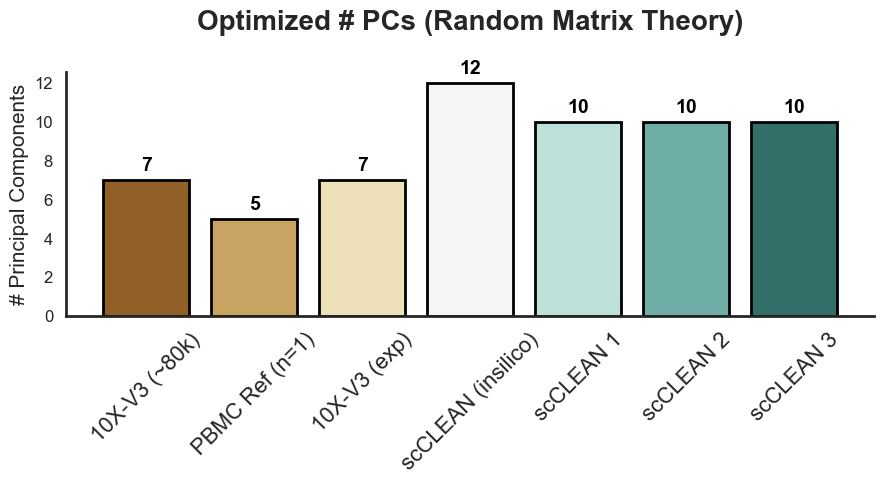

In [22]:
# Extract sample names and number of PCs for plotting
samples = [item['name'] for item in pcs_list]
PCs = [item['ncomps'] for item in pcs_list]

# Plot the bar graph
colors = ['#916026', '#C7A462', '#EEE0B8', '#F4F5F5', '#BDE0DB', '#6FAEA7', '#336F69']

fig, axes = plt.subplots(figsize=(9, 5))
axes.bar(samples, PCs, color=colors[:len(samples)], linewidth=2, edgecolor="black")

axes.set_ylabel('# Principal Components', fontsize=15)
axes.set_title('Optimized # PCs (Random Matrix Theory)', fontsize=20, pad=30, fontweight='bold')

axes.tick_params(axis='x', labelsize=16, rotation=45)
axes.tick_params(axis='y', labelsize=12)

for i, pc in enumerate(PCs):
    axes.text(i, pc + 0.5, str(pc), ha='center', fontsize=14, fontweight='bold', color='black')

axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('Comparison_PCs_Random_Matrix_Theory.png', dpi=300)
plt.show()